Statistical Comparison between Models using Cross-Validation
===

Author: Nathan A. Mahynski

Date: 2023/09/07

Description: Using cross validation to interrogate differences in model performance.

In the previous notebook models were compared using nested cross-validation so that an uncertainty on the generalization error could be obtained.  **The question becomes, how do we use this to tell if differences are statistically significant?** In principle, we can perform standard hypothesis tests to check.  However, the main problem is that these performance estimates are not independent of each other.  This tends to result in higher type I error (incorrectly reject the null hypothesis, which is two algorithms are the same) which means **you tend to see a difference in the performances when there isn't any.**  Here we will consider several different ways to proceed.

<!-- Another issue is that many of these approaches do not account for hyperparameter selection.  They tend to use disjoint training sets to train the model and evaluate on a separate test set, but if you have to do hyperameter selection usually the final model is selected based on which performs the best on these test sets.  As a result that test performance is biased - this is the reason a separate validation set is usually introduced.  The methods below neglect this, but [recent work](https://arxiv.org/pdf/1809.09446.pdf) suggests that, while this bias exists, it does not strongly affect the relative ranking of models or pipelines.-->

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !pip install git+https://github.com/mahynski/pychemauth@main

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")
    
import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [23]:
import sklearn
import scipy

import numpy as np

from imblearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import datasets

from pychemauth.analysis.compare import BiasedNestedCV
from pychemauth.analysis.compare import Compare
from pychemauth.preprocessing.scaling import CorrectedScaler

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

scipy     : 1.11.1
pychemauth: 0.0.0b3
watermark : 2.4.3
numpy     : 1.24.4
matplotlib: 3.7.2
sklearn   : 1.3.0



<h3>Load the Data</h3>

In [4]:
data = datasets.load_wine()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    shuffle=True,
    random_state=0,
    test_size=0.2
)

In [5]:
# Let's re-use these models from the last example.
def make_svc(k_inner, random_state_inner=42):
    pipe_svc = Pipeline(steps=[
        ("scaler", CorrectedScaler()),
        ("model", SVC())
    ])
    gs_svc = GridSearchCV(
        estimator=pipe_svc,
        param_grid=[{'model__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}],
        scoring='accuracy',
        cv=sklearn.model_selection.StratifiedKFold( # Since this is a classification problem we will stratify
            n_splits=k_inner,
            shuffle=True,
            random_state=random_state_inner
        ),
        refit=True
    )
    
    return gs_svc

def make_tree(k_inner, random_state_inner=42):
    gs_tree = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=0),
        param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
        scoring='accuracy',
        cv=sklearn.model_selection.StratifiedKFold( # Since this is a classification problem we will stratify
            n_splits=k_inner,
            shuffle=True,
            random_state=random_state_inner
        ),
        refit=True
    )
    
    return gs_tree

The resampled paired t-test
---

The first way to obtain uncertainties on generalization performance is simply to shuffle the data and repeat the holdout procedure to get many different test set performances.  Statistical significance can be assessed by obtaining the mean and standard deviation for each model then performing a paired [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) on the differences.  If we use the same data split then both models are tested on the same "chunk" so we should use the paired version. However, a key assumption of the t-test is that measurements are independent; as you can see below for a small subset of data, reusing the data like this means points reoccur in many training (and test) sets, meaning each result is not independent.  This has been [shown](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.37.3325&rep=rep1&type=pdf) to yield an unacceptably high [type I error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors) (detection of a difference between algorithms when there is none).

> Type I error is the rejection of the null hypothesis.  In [frequentist statistics](https://www.statisticshowto.com/frequentist-statistics/) the null hypothesis is usually formulated so that the onus is on proving a difference between two things (e.g., the difference of means), and is usually [stated in terms of](https://www.statisticshowto.com/probability-and-statistics/null-hypothesis/#state) the currently accepted [truth](https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/).  The burden of proof then falls on the researcher to disprove this and reject the current status quo in favor of something else.

In [6]:
for loop in range(3):
    X_, y_ = sklearn.utils.shuffle(X_train[:5,:2], y_train[:5], random_state=loop)
    X_train_ = X_[:3]
    X_test_ = X_[3:]
    print('Training set on fold {} :\n {}'.format(loop+1, X_train_))
    print('Test set on fold {} :\n {}'.format(loop+1, X_test_))
    print('---------------------------------')

Training set on fold 1 :
 [[11.62  1.99]
 [13.69  3.26]
 [12.69  1.53]]
Test set on fold 1 :
 [[13.4   3.91]
 [13.5   1.81]]
---------------------------------
Training set on fold 2 :
 [[11.62  1.99]
 [12.69  1.53]
 [13.5   1.81]]
Test set on fold 2 :
 [[13.69  3.26]
 [13.4   3.91]]
---------------------------------
Training set on fold 3 :
 [[11.62  1.99]
 [13.5   1.81]
 [12.69  1.53]]
Test set on fold 3 :
 [[13.4   3.91]
 [13.69  3.26]]
---------------------------------


The k-fold CV paired t-test
---

A slight improvement: split data into k disjoint folds (as in CV), and **using the same data split** evaluate each model.  The problem now is that each data point contributes to exactly $k-1$ training sets; therefore the scores estimated from the remaining fold will still be correlated, in general, because they are trained (and tested) on some of the same data.  However, note that when $k=2$ the data overlap problem goes away! The tradeoff is that we have only 2 estimates of the performance (2 test sets).

In [7]:
cv = sklearn.model_selection.StratifiedKFold(n_splits=2, random_state=42, shuffle=True)

for train_index, test_index in cv.split(X_train[:20], y_train[:20]):
    print(train_index, test_index)

[ 1  6  9 10 11 13 14 16 17 19] [ 0  2  3  4  5  7  8 12 15 18]
[ 0  2  3  4  5  7  8 12 15 18] [ 1  6  9 10 11 13 14 16 17 19]


In [8]:
# We can then evalute a model on each test set using cross-validation
scores = cross_val_score(
    estimator=DecisionTreeClassifier(random_state=0, max_depth=3), 
    X=X_train[:20],
    y=y_train[:20],
    cv=cv
)

This produces k estimates which we can get a mean and uncertainty from.

In [9]:
print('Raw scores: {}\nMean : {}\nSt. Dev. : {}'.format(scores, '%.3f'%np.mean(scores), '%.3f'%np.std(scores)))

Raw scores: [0.6 0.5]
Mean : 0.550
St. Dev. : 0.050


The repeated k-fold CV paired t-test
---

Using $k=2$ helped remove the some bias due to re-use of data in training sets, but 2 error estimates is really not enough to be very helpful.  [Dietterich popularized](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.37.3325&rep=rep1&type=pdf) a 5x2 repeated CV scheme.  This essentially combines both ideas from the last section by shuffling the data differently 5 times, then doing 2-fold CV in each shuffle.  Of course, this re-uses data due to the reshuffling and so estimates are not completely independent, but was shown to have a tolerably elevated [type I error rate](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors).  This gives us 10 estimates instead of 2.

In [10]:
# Here is a simple example of how this splitting occurs
X_dummy = X_train[:10] 
y_dummy = y_train[:10] 

rkf = RepeatedKFold(n_splits=2, n_repeats=5, random_state=0)
rkf.get_n_splits(X_dummy, y_dummy)

for i, (train_index, test_index) in enumerate(rkf.split(X_dummy)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0 3 5 6 7]
  Test:  index=[1 2 4 8 9]
Fold 1:
  Train: index=[1 2 4 8 9]
  Test:  index=[0 3 5 6 7]
Fold 2:
  Train: index=[0 4 6 7 8]
  Test:  index=[1 2 3 5 9]
Fold 3:
  Train: index=[1 2 3 5 9]
  Test:  index=[0 4 6 7 8]
Fold 4:
  Train: index=[0 1 6 7 9]
  Test:  index=[2 3 4 5 8]
Fold 5:
  Train: index=[2 3 4 5 8]
  Test:  index=[0 1 6 7 9]
Fold 6:
  Train: index=[0 3 4 5 8]
  Test:  index=[1 2 6 7 9]
Fold 7:
  Train: index=[1 2 6 7 9]
  Test:  index=[0 3 4 5 8]
Fold 8:
  Train: index=[0 3 6 8 9]
  Test:  index=[1 2 4 5 7]
Fold 9:
  Train: index=[1 2 4 5 7]
  Test:  index=[0 3 6 8 9]


In [11]:
# Here is how 5x2 repeated CV is performed
rkf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=0)

pipe1 = pipe_svc = Pipeline(steps=[
            ("scaler", CorrectedScaler()),
            ("model", SVC(C=1.0))
        ])
pipe2 = DecisionTreeClassifier(random_state=0, max_depth=3)

scores1 = []
scores2 = []
for train_index, test_index in rkf.split(X_train, y_train):
    X_train_, X_test_ = X_train[train_index], X_train[test_index]
    y_train_, y_test_ = y_train[train_index], y_train[test_index]

    # Train both pipelines on the same data and evaluate on the same test set
    pipe1.fit(X_train_, y_train_)
    scores1.append(pipe1.score(X_test_, y_test_))

    pipe2.fit(X_train_, y_train_)
    scores2.append(pipe2.score(X_test_, y_test_))

In [12]:
# We can take the difference from each run because both pipelines tested/trained on the same data each time
difference = np.array(scores2) - np.array(scores1)

In [13]:
difference

array([-0.07042254, -0.12676056, -0.11267606, -0.07042254, -0.05633803,
        0.        , -0.05633803, -0.05633803, -0.05633803,  0.        ])

In [63]:
# You can get identical results from cross_val_score like this
scores1 = cross_val_score(
    estimator=pipe1, 
    X=X_train,
    y=y_train,
    cv=rkf,
)

scores2 = cross_val_score(
    estimator=pipe2, 
    X=X_train,
    y=y_train,
    cv=rkf
)

difference = np.array(scores2) - np.array(scores1)

In [64]:
difference

array([-0.07042254, -0.12676056, -0.11267606, -0.07042254, -0.05633803,
        0.        , -0.05633803, -0.05633803, -0.05633803,  0.        ])

In [65]:
# PyChemAuth has a built in function to perform this.
# Be sure any random states are set in your pipelines and to set the random_state here as well.
scores1, scores2 = Compare.repeated_kfold(pipe1, pipe2, X_train, y_train, n_repeats=5, k=2, random_state=0)
difference = np.array(scores2) - np.array(scores1)
difference

array([-0.07042254, -0.12676056, -0.11267606, -0.07042254, -0.05633803,
        0.        , -0.05633803, -0.05633803, -0.05633803,  0.        ])

**Importantly,** the t-statistic used by Dietterich for his 5x2 CV t-test is modified from a conventional t-statistic, but we will not use it here anyway.  A example implementation is discussed [here](https://www.kaggle.com/code/ogrellier/parameter-tuning-5-x-2-fold-cv-statistical-test/notebook).

In general we can perform CV any number of times to get many test performances to improve our assessment of the relative performance. Assuming $n = r \times k$ runs have been performed, we can define the difference in test set performances between algorithms A and B for a fold in a certain repeat as $x_j = A_j - B_j$, and $\hat{s}^2 = \frac{1}{n-1}\sum(x_j - \bar{x})^2$ (unbiased sample variance).  This is used with the Student's t distribution and $n-1$ degrees of freedom.

$$
t = \frac{ \frac{1}{n} \sum_{j=1}^n x_j}{\sqrt{ \hat{s}^2 } /\sqrt{n} } =  \frac{ \frac{1}{n} \sum_{j=1}^n x_j}{\sqrt{ \frac{1}{n} \hat{s}^2 } }
$$

Dietterich originally found that the standard t-statistic was elevated and therefore needed some correction so he used a different formula;  [Nadeau & Bengio suggested a different correction](https://link.springer.com/article/10.1023/A:1024068626366) to the t-statistic which is designed to "overestimate the variance to yield conservative inference." This has a similar effect of deflating the t-statistic to account for correlations between the data folds. Here, $\rho = 1/k$ is the fraction of the data used for training.

$$
t_{\rm corrected} =  \frac{ \frac{1}{n} \sum_{j=1}^n x_j}{\sqrt{ \left( \frac{1}{n} + \frac{\rho}{1 - \rho} \right) \hat{s}^2 } }
$$

In 2004, [Bouckaert & Frank](https://link.springer.com/chapter/10.1007/978-3-540-24775-3_3) argued that reproducility is more important than minimizing type I error; this depends strongly on how the data is partitioned since different researchers will probably have different RNG seeds when trying to repeat each others' work. Instead they recommend either (a) 100 runs of random resampling or (b) 10×10 repeated cross-validation with the Nadeau and Bengio correction (discussed above).  Interestingly, (a) is the worst thing you can do according to Dietterich, so the latter is recommended.

In [66]:
def significance(alpha, scores_svc, scores_tree, n_repeats):
    """Check the significance of any differences."""
    p_value = Compare.corrected_t(
        scores_svc, # One with the best average
        scores_tree,
        n_repeats=n_repeats 
    )

    if p_value < alpha: # Reject H0
        print('SVC outperforms the Tree ({} < {})'.format('%.4f'%p_value, '%.2f'%alpha)) 
    else: # Fail to reject H0
        print('Pipelines are about the same ({} >= {})'.format('%.4f'%p_value, '%.2f'%alpha))

In [114]:
# You can perform a 2-sided test to check if algorithms are different; however, it is often the case that we develop a 
# simpler algorithm that might appear to perform a bit worse than some state-of-the-art one, and we need to check if
# its underperformance is actually statistically significant.  For this we can perform 1-sided test to see if the mean
# performance of the model with the better average is, in fact, better than the one that is worse.

# Here the SVC (scores1) seem to be better than the decision tree (scores2).  Let's do a 1-sided hypothesis test.
scores1, scores2 = Compare.repeated_kfold(pipe1, pipe2, X_train, y_train, n_repeats=5, k=2, random_state=0)

print('%dx%d Nested CV accuracy for SVC: %.3f +/- %.3f' % (5, 2, np.mean(scores1), np.std(scores1)))
print('%dx%d Nested CV accuracy for Tree: %.3f +/- %.3f' % (5, 2, np.mean(scores2), np.std(scores2)))

significance(alpha=0.05, scores_svc=scores1, scores_tree=scores2, n_repeats=5)

5x2 Nested CV accuracy for SVC: 0.968 +/- 0.027
5x2 Nested CV accuracy for Tree: 0.907 +/- 0.031
Pipelines are about the same (0.0934 >= 0.05)


In [115]:
# 10x10 is the recommendation, and clearly yields different results!
scores1, scores2 = Compare.repeated_kfold(pipe1, pipe2, X_train, y_train, n_repeats=10, k=10, random_state=0)

print('%dx%d Nested CV accuracy for SVC: %.3f +/- %.3f' % (10, 10, np.mean(scores1), np.std(scores1)))
print('%dx%d Nested CV accuracy for Tree: %.3f +/- %.3f' % (10, 10, np.mean(scores2), np.std(scores2)))

significance(alpha=0.05, scores_svc=scores1, scores_tree=scores2, n_repeats=10)

10x10 Nested CV accuracy for SVC: 0.978 +/- 0.037
10x10 Nested CV accuracy for Tree: 0.930 +/- 0.059
SVC outperforms the Tree (0.0103 < 0.05)


The (repeated) nested k-fold paired t-test
---

In the previous notebook we used nested CV because we needed to get an error estimate that accounts for **both the model fitting and its hyperparameter search.**  Until now we have just been comparing pipelines with fixed hyperparameters; often we need to optimize those as well, so nested CV is necessary.  In principle, we can simply apply the corrected t-statistic to the results from the test folds generated by nested CV. (Image credit to [Python Machine Learning, 3rd Ed.](https://github.com/rasbt/python-machine-learning-book-3rd-edition/) by Raschka and Mirjalili.)

<img src="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/images/06_07.png?raw=true" style="width:500px;">

In this 5x2 nested CV example, we would have 5 test set estimates (r=1, k=5) and can use the corrected t-test above, and/or repeat this several times so that r > 1.

<!-- There is sometimes confusion surrounding the terminology since nested CV should be referred to as $r \times k$ *nested* CV, while repeated CV is usually referred to as $r \times k$ CV.  Both are sometimes lazily referred to as simply $r \times k$ CV, but they are **not the same.**

See this stackexchange [discussion](https://stats.stackexchange.com/questions/151710/nested-cross-validation-how-is-it-different-from-model-selection-via-kfold-cv). -->

In [54]:
# Nested CV is equivalent to using the repeated k-fold with only 1 repeat, assuming we pass grid search objects 
# equipped with CV splitters.

def compare(k_inner, k_outer, n_repeats):
    scores1, scores2 = Compare.repeated_kfold(
        pipe1=GridSearchCV(
            estimator=Pipeline(steps=[
                ("scaler", CorrectedScaler()),
                ("model", SVC())
            ]),
            param_grid=[{'model__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}],
            scoring='accuracy',
            cv=sklearn.model_selection.StratifiedKFold( # Since this is a classification problem we will stratify
                n_splits=k_inner, # Inner part of the nested CV is handled by this object
                shuffle=True,
                random_state=0
            ),
            refit=True # We should refit on the entire training set once optimal hyperparameters are found
        ), 
        pipe2=GridSearchCV(
            estimator=DecisionTreeClassifier(random_state=0),
            param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
            scoring='accuracy',
            cv=sklearn.model_selection.StratifiedKFold( # Since this is a classification problem we will stratify
                n_splits=k_inner, # Inner part of the nested CV is handled by this object
                shuffle=True,
                random_state=0
            ),
            refit=True # We should refit on the entire training set once optimal hyperparameters are found
        ), 
        X=X_train, 
        y=y_train, 
        n_repeats=n_repeats, 
        k=k_outer, 
        random_state=0
    )

    return scores1, scores2

Let's review in detail what is happening above.

1. `Compare.repeated_kfold` is doing `n_repeats`of a k-fold split of the data it is given.  This is the outer split (k_outer). If `n_repeats=1` then conventional nested k-fold CV is performed.
2. This is because each estimator is a `GridSearchCV` object which uses k-fold CV to do the inner loop: (1) find optimal hyperparameters, then (2) refit on the entire training fold it was given.
3. Each model is optimized, then tested on a single outer test fold so there are k_outer scores.

In fact, by specifying `n_repeats` to be more than one, we can simply perform repeated (nested) k-fold CV where we have an internal nested loop to handle hyperparameter optimization.

In [74]:
# This is just nested k-fold CV where k = k_outer = 5
scores1, scores2 = compare(k_inner=2, k_outer=5, n_repeats=1)

print('%dx%d Nested CV accuracy for SVC: %.3f +/- %.3f' % (5, 2, np.mean(scores1), np.std(scores1)))
print('%dx%d Nested CV accuracy for Tree: %.3f +/- %.3f' % (5, 2, np.mean(scores2), np.std(scores2)))

significance(alpha=0.05, scores_svc=scores1, scores_tree=scores2, n_repeats=1)

5x2 Nested CV accuracy for SVC: 0.979 +/- 0.041
5x2 Nested CV accuracy for Tree: 0.915 +/- 0.043
Pipelines are about the same (0.0900 >= 0.05)


In [118]:
# This is repeated nested k-fold CV where k = k_outer = 5
# Similar results were obtained for 10x10 repeated CV
scores1, scores2 = compare(k_inner=2, k_outer=5, n_repeats=20)

print('Repeated %dx%d Nested CV accuracy for SVC: %.3f +/- %.3f' % (5, 2, np.mean(scores1), np.std(scores1)))
print('Repeated %dx%d Nested CV accuracy for Tree: %.3f +/- %.3f' % (5, 2, np.mean(scores2), np.std(scores2)))

significance(alpha=0.05, scores_svc=scores1, scores_tree=scores2, n_repeats=20)

Repeated 5x2 Nested CV accuracy for SVC: 0.975 +/- 0.026
Repeated 5x2 Nested CV accuracy for Tree: 0.924 +/- 0.046
SVC outperforms the Tree (0.0194 < 0.05)


In [120]:
# 10x10 repeated nested CV could look like this; note k_inner should be appropriate for good hyperparameter tuning
# but neither of these "10s" refer to this.
scores1, scores2 = compare(k_inner=5, k_outer=10, n_repeats=10)

print('Repeated %dx%d Nested CV accuracy for SVC: %.3f +/- %.3f' % (10, 5, np.mean(scores1), np.std(scores1)))
print('Repeated %dx%d Nested CV accuracy for Tree: %.3f +/- %.3f' % (10, 5, np.mean(scores2), np.std(scores2)))

significance(alpha=0.05, scores_svc=scores1, scores_tree=scores2, n_repeats=10)

Repeated 10x5 Nested CV accuracy for SVC: 0.973 +/- 0.041
Repeated 10x5 Nested CV accuracy for Tree: 0.928 +/- 0.063
SVC outperforms the Tree (0.0248 < 0.05)


In [108]:
# It seems that doing more and more testing suggest that the SVC pipeline outperforms the Tree; let's examine this in 
# more detail. 

p = {}
for n_repeats in np.arange(1, 10+1, 2):
    p[n_repeats] = []
    for k_outer in [2, 4, 6, 8, 10, 12, 14, 16]:
        scores1, scores2 = compare(k_inner=5, k_outer=k_outer, n_repeats=n_repeats)
        
        p[n_repeats].append(Compare.corrected_t(
            scores1, 
            scores2,
            n_repeats=n_repeats 
        ))

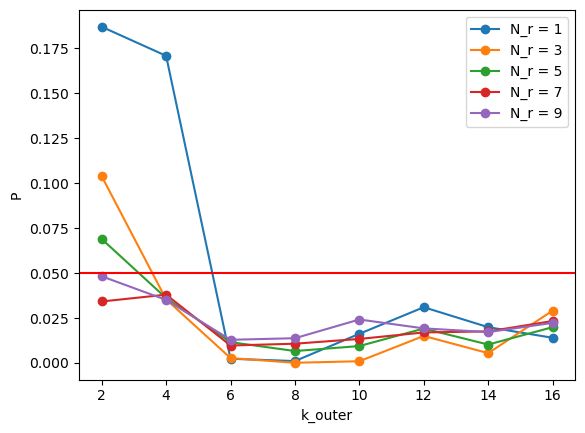

In [109]:
for n in p.keys():
    plt.plot([2, 4, 6, 8, 10, 12, 14, 16], p[n], 'o-', label='N_r = {}'.format(n))
plt.xlabel('k_outer')
plt.ylabel('P')
plt.legend(loc='best')
_ = plt.axhline(0.05, color='red')

As long as k_outer is ~ 5 or higher, the number of repeats doesn't really affect the p value.

Only very few repeats with very small k_outer (which lead to a small number of test sets, N_tot = N_r * k_outer)
result in p > 0.05 (i.e., the belief that these pipelines perform similarly).  The p-value converges as
N_tot increases.

<h3>A Shortcut</h3>

<h4>An aside about nested CV</h4>

There is another way to rank the relative performance of different pipelines described by [Wainer and Cawley](https://www.sciencedirect.com/science/article/pii/S0957417421006540).  Their argument is that nested CV is actually overzealous and simple (they term it "flat") CV is good enough to get a reasonable estimate of the **relative** performance of different models.

> "When selecting a classification algorithm to be applied to a particular problem, one has to simultaneously select the best algorithm for that dataset and the best set of hyperparameters for the chosen model. The usual approach is to apply a nested cross-validation procedure: hyperparameter selection is performed in the inner cross-validation, while the outer cross-validation computes an unbiased estimate of the expected accuracy of the algorithm with cross-validation based hyperparameter tuning. The alternative approach, which we shall call “flat cross-validation”, uses a single cross-validation step both to select the optimal hyperparameter values and to provide an estimate of the expected accuracy of the algorithm that, while biased, may nevertheless still be used to select the best learning algorithm. We tested both procedures using 12 different algorithms on 115 real-life binary datasets and conclude that using the less computationally costly flat cross-validation procedure will generally result in the selection of an algorithm that is, for all practical purposes, of similar quality to that selected via nested cross-validation, provided the learning algorithms have relatively few hyperparameters to be optimised."

* Flat Cross-Validation: We do k-fold CV to find the best hyperparameters. In the image below, k=10.  The best set of hyperparameters is determined based on the average of the k performance estimates when the model is retrained using the (k-1)/k part of the data.  In principle, we can take the average of these k values from the specific iteration when the best hyperparameters were used and obtain an estimate of this "optimal" model's performance; however, because these numbers were used to determine which hyperparameters to use in the first place, this estimate is positively biased.  That is why we typically hold out a completely separate test set to evaluate the model on, then report its generalization error based on that.

<img src="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/images/06_03.png?raw=true" style="width:500px;">

This pseudocode is based on Wainer and Cawley's paper.

~~~python
def flat(data, ...):
    cv.list = create_cv(data, ...)
    acc_max = 0.0
    for hyperparameter_set in create_grid(...):
        acc = 0.0
        for train_set, test_set in cv.list:
            model = class_train(train_set, hyperparameter_set)
            acc += accuracy(model, test_set)
        if acc > acc_max:
            acc_max = acc
            best_hyperparameters = hyperparameter_set
    return acc_max / len(cv.list), best_hyperparameters
~~~

* Nested CV: Instead, we can do a k-fold outer split of the data, then on each (k_outer-1)/k_outer data fraction we do an inner CV loop to determined the optimal hyperparameters. The optimal model based on the performance as estimated on the k_outer fraction, averaged over all k_outer folds.  

<img src="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/images/06_07.png?raw=true" style="width:500px;">

This pseudocode is based on Wainer and Cawley's paper.

~~~python
def nested(data, ...):
    acc_final = 0.0
    cv.list = create_cv(data, ...)
    for train_outer, test_outer in cv.list:
        acc_max = 0.0
        for hyperparameter_set in create_grid(...):
            acc = 0.0
            cv_inner.list = create_cv(train_outer, ...):
            for train_inner, test_inner in cv_inner.list:
                model_inner = class_train(train_inner, hyperparameter_set)
                acc += accuracy(model_inner, test_inner)
            if acc > acc_max:
                acc_max = acc
                best_hyperparameters = hyperparameter_set
        model_outer = class_train(train_outer, best_hyperparameters)
        acc_final += accuracy(model_outer, test_outer)
    return acc_final / len(cv.list)
~~~

A comparison of the performance estimates themselves is presented [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html) using sklearn and the famous Iris dataset.  However, Wainer and Cawley suggest that, although the flat CV estimate is biased, if the bias is about the same for all models, then it should not affect the **relative ranking** of the pipelines.  

> "Notice that for the purpose of algorithm selection the positive bias of the ﬂat procedure is not itself a problem provided the algorithm ranked highest by the nested procedure is the same as that highest ranked by the ﬂat procedure, which implies the degree of bias is approximately the same for all classifiers."

<h4>How can we apply this?</h4>

Consider the following algorithm.  Let's perform nested k_inner x k_outer CV.  From each outer loop we will extract each of the k_inner validation fold performances corresponding to the model with the best hyperparameters for that loop.  Repeating this for each outer loop gives us k_outer x k_inner total performance estimates.  This almost like we did repeated CV where $N_r$ = k_outer, except in this case each repeat does not use exactly the same (reshuffled) data since the outer k-fold loop ensures that 1/k_outer is held out on each iteration.  In this approach, we are actually ignoring the 1/k_outer outer test fold which we would normally use to get an unbiased estimate of the model's performance.  However, if we accept Wainer and Cawley's assertion that this generally affects all models about the same (not affecting their ranking), we can use these k_outer x k_inner total performance estimates to do a corrected t-test, as before.

Note, although each inner fold value is a biased performance estimate, there is less overall bias coming from the collection across all outer folds (repeats) than in "standard" repeated CV because the outer k-fold procedure ensures some of the data (1/k_outer) does not appear in this iteration compared to others.  As a result, the correction factor is less necessary; the tradeoff is that less data is used for training in each iteration.  Thus, there are two sources of bias which work against each other.

This image is taken from the supplementary information of [this paper](https://link.springer.com/article/10.1007/s10967-023-09024-x) which graphically illustrates the procedure using R = k_outer = 5 with k_inner = 2 loops.  Pipeline 2 is considered the one with the best average performance, so we can test the other Q-1 pipelines against this, as before.

<img src="../../_static/biased_nested_cv.png" style="width:500px;">

PyChemAuth provides a class to perform this and ensure the data splitting is the same so that a paired t-test can be performed.

In [121]:
def compare_biased_ncv(k, k_train=5):
    bcv = BiasedNestedCV(k_inner=k_train, k_outer=k)
    scores_svc = bcv.grid_search(
        pipeline = Pipeline(steps=[
            ("scaler", CorrectedScaler()),
            ("model", SVC())
        ]),
        param_grid=[{'model__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}],
        X=X_train,
        y=y_train,
        classification=True,
    )
    
    bcv = BiasedNestedCV(k_inner=k_train, k_outer=k)
    scores_tree = bcv.grid_search(
        pipeline = Pipeline(steps=[
            ("tree", DecisionTreeClassifier(random_state=0)),
        ]),
        param_grid=[{'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
        X=X_train,
        y=y_train,
        classification=True,
    )
    
    return scores_svc, scores_tree

Let's compare this comparison between our 2 candidate pipelines to the repeated nested CV approach.  The repeated nested approach uses the unbiased performance estimates to compare the pipelines.  The biased approach does not.  However, the repeated nested approach is $N_r$ (the number of repeats) times more expensive since the biased approach is just doing a single iteration of the nested CV.

In [122]:
p_biased = []
for k_outer in [2, 4, 6, 8, 10, 12, 14, 16]:
    scores_svc, scores_tree = compare_biased_ncv(k_outer, k_train=5)
    
    p_biased.append(
        Compare.corrected_t(
            scores1=scores_svc, 
            scores2=scores_tree,
            n_repeats=k_outer
        )
    )
            

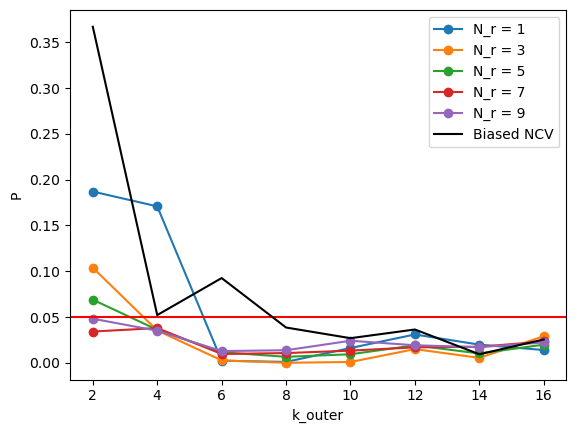

In [123]:
for n in p.keys():
    plt.plot([2, 4, 6, 8, 10, 12, 14, 16], p[n], 'o-', label='N_r = {}'.format(n))
plt.xlabel('k_outer')
plt.ylabel('P')
plt.axhline(0.05, color='red')

plt.plot([2, 4, 6, 8, 10, 12, 14, 16], p_biased, label='Biased NCV', color='k')
_ = plt.legend(loc='best')

For a small number of total comparisons (k_outer < 5 and small $N_r$) the conclusion would be different than if we ran more comparisons. The biased comparisons using 5-fold inner CV also converge to the same p value after enough comparisons.  

* Following Bouckaert & Frank's suggestion of doing 10x10 would sufficient for quantitive p value agreement. 
* Still, if it can be afforded, repeated nested CV is the least biased approach.

Both methods use Nadeau and Bengio's correction.

Rashomon Sets
---

In [ ]:
Rudin papers

No free lunch theorem

In [ ]:
# visualize

Bayesian Comparison
---

See "Time for a Change: a Tutorial for Comparing Multiple Classifiers Through Bayesian Analysis", Alessio Benavoli, Giorgio Corani, Janez Demšar, Marco Zaffalon. Journal of Machine Learning Research, 18 (2017) 1-36.

They have an associated [github repo](https://github.com/janezd/baycomp) and [documentation](https://baycomp.readthedocs.io/en/latest/) that discusses the advantages of using Bayesian methods to compare ML pipelines instead of frequentist statistics (hypothesis testing).

More discussion [here](https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/) on the argument for (and against) using Bayesian statistics instead of frequentist.